313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
313/31

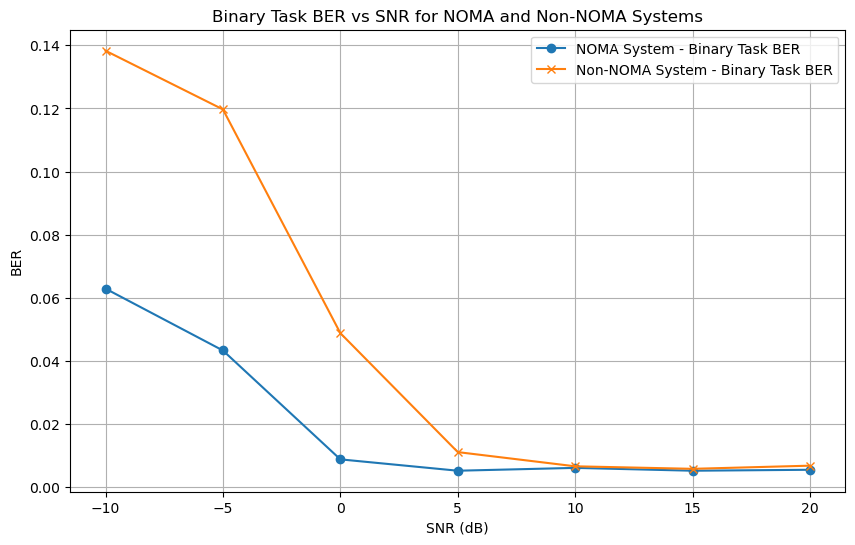

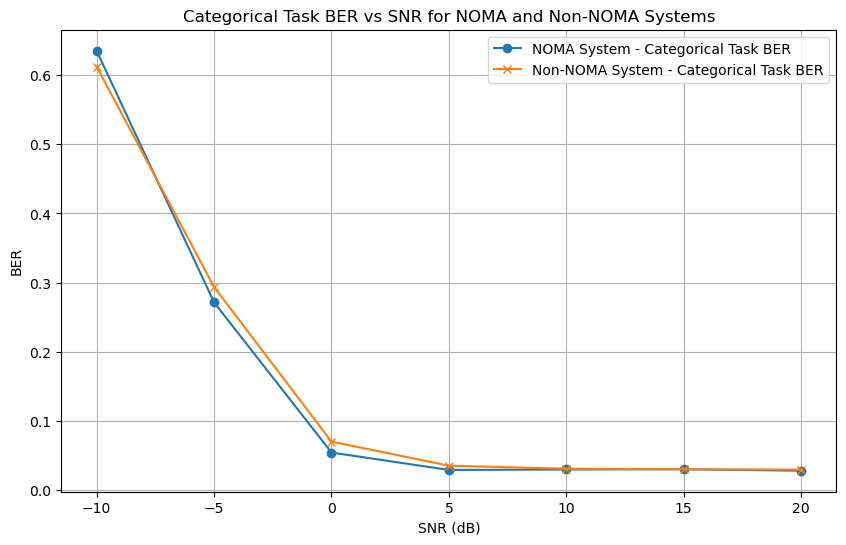

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the data and normalize
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255.0
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255.0

# Define the AWGN function
def add_awgn_noise(signal, snr_db):
    """Add AWGN noise to the signal with a given SNR in dB."""
    snr = 10 ** (snr_db / 10.0)
    signal_power = tf.reduce_mean(tf.square(signal))
    noise_power = signal_power / snr
    noise = tf.random.normal(shape=tf.shape(signal), mean=0.0, stddev=tf.sqrt(noise_power))
    return signal + noise

# Binary classification labels for Task 1 (digit "2")
y_train_binary = (y_train == 2).astype('float32')
y_test_binary = (y_test == 2).astype('float32')

# Categorical classification labels for Task 2
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

# Create sample weights for the binary classification task
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_binary), y=y_train_binary)
sample_weights_binary = np.where(y_train_binary == 1, class_weights[1], class_weights[0])

# Define the CU Encoder (common to both systems)
class CUEncoder(tf.keras.Model):
    def __init__(self):
        super(CUEncoder, self).__init__()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(64, activation='tanh')
    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.fc(x)
        return x

# BPSK Modulation (for binary task)
def bpsk_modulate(signal):
    """Perform BPSK modulation: Map 0 -> -1 and 1 -> 1."""
    return 2 * signal - 1

# NOMA System (code1)
class SU1_System1(tf.keras.Model):
    def __init__(self):
        super(SU1_System1, self).__init__()
        self.encoder = layers.Dense(16, activation='tanh')
    
    def call(self, inputs):
        return self.encoder(inputs)

class SU2_System1(tf.keras.Model):
    def __init__(self):
        super(SU2_System1, self).__init__()
        self.encoder = layers.Dense(16, activation='tanh')
    
    def call(self, inputs):
        return self.encoder(inputs)

def noma_superimpose(x1, x2, power1=0.6, power2=0.4):
    """Superimpose two signals using different power levels as per NOMA."""
    return tf.sqrt(power1) * x1 + tf.sqrt(power2) * x2

class BaseStation_System1(tf.keras.Model):
    def __init__(self):
        super(BaseStation_System1, self).__init__()
        self.dnn = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu')
        ])
        self.su1_decoder = layers.Dense(1, activation='sigmoid', name='binary_output')
        self.su2_decoder = layers.Dense(10, activation='softmax', name='categorical_output')
    
    def call(self, inputs):
        x = self.dnn(inputs)
        su1_output = self.su1_decoder(x)
        su2_output = self.su2_decoder(x)
        return {'binary_output': su1_output, 'categorical_output': su2_output}

class MultiTaskNOMA(tf.keras.Model):
    def __init__(self, snr_db):
        super(MultiTaskNOMA, self).__init__()
        self.cu_encoder = CUEncoder()
        self.su1 = SU1_System1()
        self.su2 = SU2_System1()
        self.base_station = BaseStation_System1()
        self.snr_db = snr_db
    
    def call(self, inputs):
        cu_output = self.cu_encoder(inputs)
        su1_output = self.su1(cu_output)
        su2_output = self.su2(cu_output)
        su1_modulated = bpsk_modulate(su1_output)
        su2_modulated = bpsk_modulate(su2_output)
        superimposed_signal = noma_superimpose(su1_modulated, su2_modulated)
        noisy_signal = add_awgn_noise(superimposed_signal, self.snr_db)
        return self.base_station(noisy_signal)

# Non-NOMA System (code3)
class SU1_System3(tf.keras.Model):
    def __init__(self, snr_db):
        super(SU1_System3, self).__init__()
        self.encoder = layers.Dense(16, activation='tanh')
        self.snr_db = snr_db
        self.decoder = layers.Dense(1, activation='sigmoid', name='binary_output')
    
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        x = bpsk_modulate(x)
        x = add_awgn_noise(x, self.snr_db)
        return x

class SU2_System3(tf.keras.Model):
    def __init__(self, snr_db):
        super(SU2_System3, self).__init__()
        self.encoder = layers.Dense(16, activation='tanh')
        self.snr_db = snr_db
        self.decoder = layers.Dense(10, activation='softmax', name='categorical_output')
    
    def call(self, inputs):
        x = self.encoder(inputs)
        x = add_awgn_noise(x, self.snr_db)
        x = self.decoder(x)
        return x

class MultiTaskNonNOMA(tf.keras.Model):
    def __init__(self, snr_db):
        super(MultiTaskNonNOMA, self).__init__()
        self.cu_encoder = CUEncoder()
        self.su1 = SU1_System3(snr_db)
        self.su2 = SU2_System3(snr_db)
    
    def call(self, inputs):
        cu_output = self.cu_encoder(inputs)
        su1_output = self.su1(cu_output)
        su2_output = self.su2(cu_output)
        return {'binary_output': su1_output, 'categorical_output': su2_output}

# Function to calculate BER for binary and categorical tasks
def calculate_ber(y_true, y_pred, task_type='binary'):
    if task_type == 'binary':
        y_pred_binary = (y_pred >= 0.5).astype(int)
        y_pred_binary = np.squeeze(y_pred_binary)
        y_true = y_true.astype(int)
    elif task_type == 'categorical':
        y_pred_binary = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)
    
    # Check for shape mismatches
    if y_true.shape != y_pred_binary.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape}, y_pred_binary shape {y_pred_binary.shape}")
    
    # Count the number of bit errors
    bit_errors = np.sum(y_true != y_pred_binary)
    total_bits = y_true.size
    ber = bit_errors / total_bits
    return ber

# SNR values to test
snr_values = [-10, -5, 0, 5, 10, 15, 20]

# Lists to store BER for each SNR level
binary_ber_noma_list = []
categorical_ber_noma_list = []
binary_ber_non_noma_list = []
categorical_ber_non_noma_list = []

# Loop over different SNR values and calculate BER for both systems
for snr_db in snr_values:
    # NOMA system (code1)
    noma_model = MultiTaskNOMA(snr_db)
    noma_model.compile(optimizer='adam',
                       loss={'binary_output': 'binary_crossentropy', 'categorical_output': 'categorical_crossentropy'},
                       metrics={'binary_output': 'accuracy', 'categorical_output': 'accuracy'})
    
    noma_model.fit(x_train, 
                   {'binary_output': y_train_binary, 'categorical_output': y_train_categorical},
                   sample_weight={'binary_output': sample_weights_binary, 'categorical_output': np.ones_like(y_train_binary)},
                   epochs=50, 
                   batch_size=128,
                   validation_data=(x_test, {'binary_output': y_test_binary, 'categorical_output': y_test_categorical}),
                   verbose=0)
    
    evaluation_results_noma = noma_model.evaluate(x_test, {'binary_output': y_test_binary, 'categorical_output': y_test_categorical}, verbose=0)
    y_pred_binary_noma = noma_model.predict(x_test)['binary_output']
    binary_ber_noma = calculate_ber(y_test_binary, y_pred_binary_noma, task_type='binary')
    binary_ber_noma_list.append(binary_ber_noma)
    
    y_pred_categorical_noma = noma_model.predict(x_test)['categorical_output']
    categorical_ber_noma = calculate_ber(y_test_categorical, y_pred_categorical_noma, task_type='categorical')
    categorical_ber_noma_list.append(categorical_ber_noma)

    # Non-NOMA system (code3)
    non_noma_model = MultiTaskNonNOMA(snr_db)
    non_noma_model.compile(optimizer='adam',
                           loss={'binary_output': 'binary_crossentropy', 'categorical_output': 'categorical_crossentropy'},
                           metrics={'binary_output': 'accuracy', 'categorical_output': 'accuracy'})
    
    non_noma_model.fit(x_train, 
                       {'binary_output': y_train_binary, 'categorical_output': y_train_categorical},
                       sample_weight={'binary_output': sample_weights_binary, 'categorical_output': np.ones_like(y_train_binary)},
                       epochs=30, 
                       batch_size=128,
                       validation_data=(x_test, {'binary_output': y_test_binary, 'categorical_output': y_test_categorical}),
                       verbose=0)
    
    evaluation_results_non_noma = non_noma_model.evaluate(x_test, {'binary_output': y_test_binary, 'categorical_output': y_test_categorical}, verbose=0)
    y_pred_binary_non_noma = non_noma_model.predict(x_test)['binary_output']
    binary_ber_non_noma = calculate_ber(y_test_binary, y_pred_binary_non_noma, task_type='binary')
    binary_ber_non_noma_list.append(binary_ber_non_noma)
    
    y_pred_categorical_non_noma = non_noma_model.predict(x_test)['categorical_output']
    categorical_ber_non_noma = calculate_ber(y_test_categorical, y_pred_categorical_non_noma, task_type='categorical')
    categorical_ber_non_noma_list.append(categorical_ber_non_noma)

# Plot BER vs SNR for binary task
plt.figure(figsize=(10, 6))
plt.plot(snr_values, binary_ber_noma_list, marker='o', label='NOMA System - Binary Task BER')
plt.plot(snr_values, binary_ber_non_noma_list, marker='x', label='Non-NOMA System - Binary Task BER')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Binary Task BER vs SNR for NOMA and Non-NOMA Systems')
plt.grid(True)
plt.legend()
plt.show()

# Plot BER vs SNR for categorical task
plt.figure(figsize=(10, 6))
plt.plot(snr_values, categorical_ber_noma_list, marker='o', label='NOMA System - Categorical Task BER')
plt.plot(snr_values, categorical_ber_non_noma_list, marker='x', label='Non-NOMA System - Categorical Task BER')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Categorical Task BER vs SNR for NOMA and Non-NOMA Systems')
plt.grid(True)
plt.legend()
plt.show()

